<h1 align="center">TensorFlow Neural Network - Digit Detection</h1>

<img src="image/notmnist.png">
The data we are are using, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consists of images of a letter from A to J in different fonts.

The above images are a few examples of the data.

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


The notMNIST dataset is too large.  It contains 500,000 images for just training.  We have used a subset of this data, 15,000 images for each label (A-J).

In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

Download Finished
Download Finished
All files downloaded.


In [3]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|██████████| 10001/10001 [00:02<00:00, 4909.39files/s]


All features and labels uncompressed.


<img src="image/Mean_Variance_Image.png" style="height: 75%;width: 75%; position: relative; right: 5%">

Implemented Min-Max scaling in the `normalize_grayscale()` function to a range of `a=0.1` and `b=0.9`. After scaling, the values of the pixels in the input data should range from 0.1 to 0.9.

Since the raw notMNIST image data is in [grayscale](https://en.wikipedia.org/wiki/Grayscale), the current values range from a min of 0 to a max of 255.

Min-Max Scaling:
$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$

In [29]:
def normalize_grayscale(image_data):
    """
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ))

In [14]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [15]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [16]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


# Checkpoint
All your progress is now saved to the pickle file.

In [17]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print('Data and modules loaded.')

/media/kartik_nighania/data/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/media/kartik_nighania/data/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Data and modules loaded.



## Problem 2

Now it's time to build a simple neural network using TensorFlow. Network will be just an input layer and an output layer.

<img src="image/network_diagram.png" style="height: 40%;width: 40%; position: relative; right: 10%">

For the input here the images have been flattened into a vector of $28 \times 28 = 784$ features. Then, we're trying to predict the image digit so there are 10 output units, one for each label.

For the neural network to train on your data, we have 3 parameters: <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - Placeholder tensor for feature data (`train_features`/`valid_features`/`test_features`)
 - `labels`
  - Placeholder tensor for label data (`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - Variable Tensor with random numbers from a truncated normal distribution.

In [35]:
# All the pixels in the image (28 * 28 = 784)
features_count = 784
# All the labels
labels_count = 10

features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))

#Test Cases
from tensorflow.python.ops.variables import Variable

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [36]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


<img src="image/Learn_Rate_Tune_Image.png" style="height: 70%;width: 70%"> </img>
## Hyper-Parameter optimization

Epoch  1/1: 100%|██████████| 1114/1114 [00:08<00:00, 134.90batches/s]


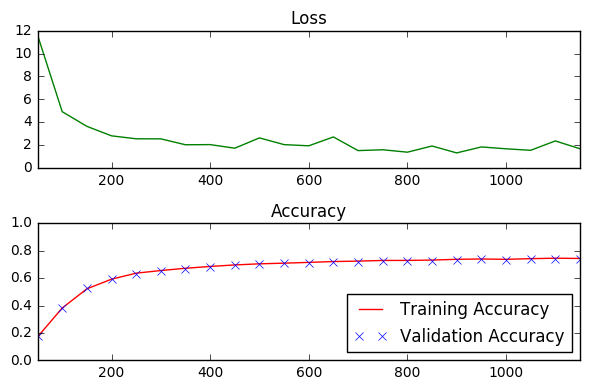

Validation accuracy at 0.7188000082969666


In [38]:
# Change if you have memory restrictions
batch_size = 128
epochs = 1
learning_rate = 0.1

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

## Testing

In [39]:
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

print('Test Accuracy is {}'.format(test_accuracy))

Epoch  1/1: 100%|██████████| 1114/1114 [00:02<00:00, 527.21batches/s]


Test Accuracy is 0.8029999732971191
